In [9]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from datetime import datetime, timedelta
import calendar
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, Markdown, HTML

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 11

# Suppress warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [10]:
# Cell 2: Load Insurance Data with Time Focus
print("="*80)
print("📂 LOADING INSURANCE DATA FOR TEMPORAL ANALYSIS")
print("="*80)

from pathlib import Path
import pandas as pd

# Use your confirmed path
data_path = Path("../../data/01_interim/cleaned_data.txt")  # Use cleaned_data.txt

print(f"🔍 Data path: {data_path.absolute()}")

if data_path.exists():
    file_size_mb = data_path.stat().st_size / (1024**2)
    print(f"✅ FOUND: cleaned_data.txt ({file_size_mb:.1f} MB)")
    
    # Load the ENTIRE file (remove nrows parameter)
    print("📥 Loading full dataset...")
    
    try:
        # First detect delimiter
        with open(data_path, 'r', encoding='utf-8') as f:
            first_line = f.readline()
        
        # Simple delimiter detection
        if '\t' in first_line and first_line.count('\t') > first_line.count(','):
            delimiter = '\t'
        elif '|' in first_line and first_line.count('|') > first_line.count(','):
            delimiter = '|'
        else:
            delimiter = ','  # Default to comma
            
        print(f"🔍 Detected delimiter: {repr(delimiter)}")
        
        # Load ALL data (no nrows limit)
        df = pd.read_csv(
            data_path,
            delimiter=delimiter,
            low_memory=False,
            encoding='utf-8',
            on_bad_lines='warn'  # or 'skip' if there are bad lines
        )
        
        print(f"✅ SUCCESS: Loaded {len(df):,} rows × {df.shape[1]} columns (FULL DATASET)")
        print(f"💾 Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
    except Exception as e:
        print(f"❌ Error loading full dataset: {e}")
        print("🔄 Trying alternative delimiter...")
        df = pd.read_csv(data_path, low_memory=False, on_bad_lines='warn')
        print(f"✅ Loaded using default settings")
        
else:
    print(f"❌ ERROR: File not found!")
    print(f"📋 Current directory: {Path.cwd()}")
    raise FileNotFoundError("cleaned_data.txt not found at specified path")

# Display data overview (now with full dataset)
print(f"\n📊 FULL DATASET Information:")
print(f"   • Total Rows: {df.shape[0]:,}")
print(f"   • Total Columns: {df.shape[1]}")
print(f"   • Missing values: {df.isnull().sum().sum():,}")

print(f"\n🔍 First 3 rows of REAL DATA:")
display(df.head(3))

print(f"\n📋 Data Types in FULL DATASET:")
print(df.dtypes.value_counts())

📂 LOADING INSURANCE DATA FOR TEMPORAL ANALYSIS
🔍 Data path: d:\10 acadamy\insurance anlysis\Insurance_Risk_Analytics_Predictive_modeling\notebooks\task1_eda\..\..\data\01_interim\cleaned_data.txt
✅ FOUND: cleaned_data.txt (538.5 MB)
📥 Loading full dataset...
🔍 Detected delimiter: '|'
✅ SUCCESS: Loaded 1,000,098 rows × 52 columns (FULL DATASET)
💾 Memory: 2532.4 MB

📊 FULL DATASET Information:
   • Total Rows: 1,000,098
   • Total Columns: 52
   • Missing values: 1,000,650

🔍 First 3 rows of REAL DATA:


,underwrittencoverid,policyid,transactionmonth,isvatregistered,citizenship,legaltype,title,language,bank,accounttype,...,excessselected,covercategory,covertype,covergroup,section,product,statutoryclass,statutoryrisktype,totalpremium,totalclaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0



📋 Data Types in FULL DATASET:
object     37
float64    11
int64       3
bool        1
Name: count, dtype: int64


In [11]:
# Cell 3: Time Variable Preparation
print("="*80)
print("🔍 IDENTIFYING & PREPARING TIME VARIABLES")
print("="*80)

def prepare_time_variables(df):
    """Identify and prepare time-related variables"""
    
    # Find datetime columns
    datetime_cols = []
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            datetime_cols.append(col)
        elif 'date' in col.lower() or 'time' in col.lower() or 'month' in col.lower():
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce')
                if pd.api.types.is_datetime64_any_dtype(df[col]):
                    datetime_cols.append(col)
            except:
                pass
    
    print(f"📅 Datetime columns found: {len(datetime_cols)}")
    for i, col in enumerate(datetime_cols, 1):
        non_null = df[col].notnull().sum()
        pct = non_null / len(df) * 100
        date_range = f"{df[col].min().date()} to {df[col].max().date()}" if non_null > 0 else "No valid dates"
        print(f"   {i:2d}. {col:25} Non-null: {non_null:,} ({pct:.1f}%) | Range: {date_range}")
    
    # Create time-based features from the primary date column
    if datetime_cols:
        primary_date = datetime_cols[0]  # Use first datetime column
        
        print(f"\n⏰ Creating temporal features from '{primary_date}':")
        
        # Extract time components
        df['Year'] = df[primary_date].dt.year
        df['Month'] = df[primary_date].dt.month
        df['Month_Name'] = df[primary_date].dt.month_name()
        df['Quarter'] = df[primary_date].dt.quarter
        df['Week'] = df[primary_date].dt.isocalendar().week
        df['Day'] = df[primary_date].dt.day
        df['DayOfWeek'] = df[primary_date].dt.day_name()
        df['DayOfYear'] = df[primary_date].dt.dayofyear
        df['Is_Weekend'] = df[primary_date].dt.dayofweek >= 5
        
        print(f"   ✅ Created: Year, Month, Quarter, Week, Day, DayOfWeek, DayOfYear, Is_Weekend")
        
        # Calculate time-based metrics
        df['Days_Since_First'] = (df[primary_date] - df[primary_date].min()).dt.days
        df['Days_Since_Previous'] = df[primary_date].diff().dt.days
        
        print(f"   ✅ Created: Days_Since_First, Days_Since_Previous")
        
        return df, primary_date, datetime_cols
    else:
        print("⚠️ No datetime columns found. Creating synthetic time index...")
        df['Synthetic_Date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
        primary_date = 'Synthetic_Date'
        
        # Create same temporal features
        df['Year'] = df[primary_date].dt.year
        df['Month'] = df[primary_date].dt.month
        df['Month_Name'] = df[primary_date].dt.month_name()
        df['Quarter'] = df[primary_date].dt.quarter
        df['DayOfWeek'] = df[primary_date].dt.day_name()
        
        return df, primary_date, ['Synthetic_Date']

# Execute preparation
df, primary_date_col, datetime_cols = prepare_time_variables(df)

print(f"\n📋 New temporal features:")
temp_features = ['Year', 'Month', 'Quarter', 'DayOfWeek', 'Is_Weekend']
for feat in temp_features:
    if feat in df.columns:
        unique_vals = df[feat].nunique()
        print(f"   • {feat:15} : {unique_vals} unique values")

🔍 IDENTIFYING & PREPARING TIME VARIABLES
📅 Datetime columns found: 2
    1. transactionmonth          Non-null: 1,000,098 (100.0%) | Range: 2013-10-01 to 2015-08-01
    2. vehicleintrodate          Non-null: 999,546 (99.9%) | Range: 1977-10-01 to 2014-09-01

⏰ Creating temporal features from 'transactionmonth':
   ✅ Created: Year, Month, Quarter, Week, Day, DayOfWeek, DayOfYear, Is_Weekend
   ✅ Created: Days_Since_First, Days_Since_Previous

📋 New temporal features:
   • Year            : 3 unique values
   • Month           : 12 unique values
   • Quarter         : 4 unique values
   • DayOfWeek       : 7 unique values
   • Is_Weekend      : 2 unique values


📈 BASIC TIME SERIES VISUALIZATION

🔍 Analyzing temporal patterns...
✅ Found 11 potential date columns: ['transactionmonth', 'registrationyear', 'vehicleintrodate', 'Year', 'Month', 'Month_Name', 'Day', 'DayOfWeek', 'DayOfYear', 'Days_Since_First', 'Days_Since_Previous']
📅 Using date column: transactionmonth

📈 Available metrics for time series analysis:
   1. totalpremium (missing: 0.0%)
   2. totalclaims (missing: 0.0%)
   3. suminsured (missing: 0.0%)
   4. calculatedpremiumperterm (missing: 0.0%)
   5. excessselected (missing: 0.0%)

📊 Analyzing: totalpremium over time...

📊 Time Series Analysis: totalpremium over Time
   • Date column: transactionmonth
   • Value column: totalpremium
   • Frequency: M


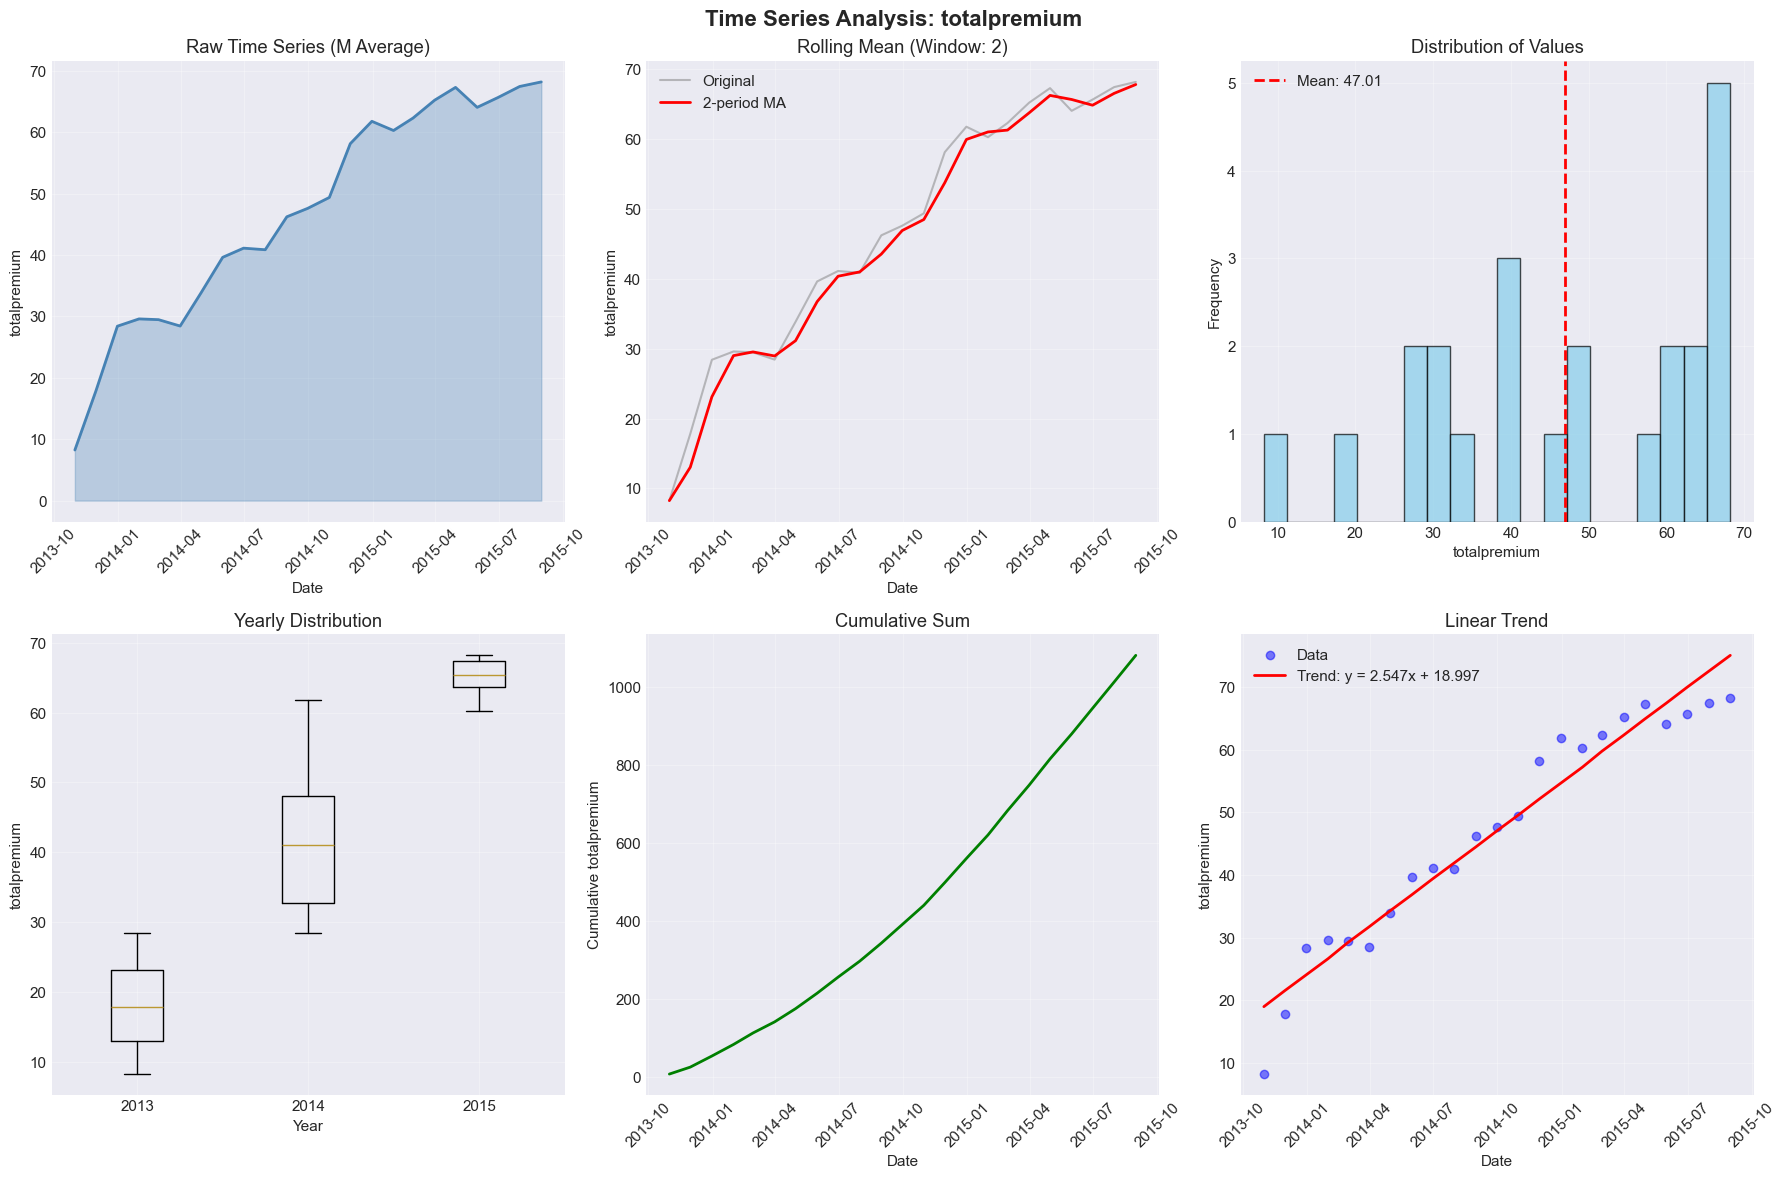


📊 Time Series Statistics:
   • Time Range: 2013-10-31 to 2015-08-31
   • Number of periods: 23
   • Mean: 47.01
   • Std Dev: 17.80
   • Min: 8.25
   • Max: 68.21
   • Trend (slope): 2.5468

✅ TIME SERIES VISUALIZATION COMPLETE


In [12]:
# Cell 4: Basic Time Series Visualization
print("="*80)
print("📈 BASIC TIME SERIES VISUALIZATION")
print("="*80)

def visualize_time_series(df, date_col, value_col, freq='M'):
    """
    Create comprehensive time series visualization
    """
    print(f"\n📊 Time Series Analysis: {value_col} over Time")
    print(f"   • Date column: {date_col}")
    print(f"   • Value column: {value_col}")
    print(f"   • Frequency: {freq}")
    
    # Prepare data
    data = df[[date_col, value_col]].dropna()
    
    if len(data) < 10:
        print(f"⚠️ Insufficient data for time series analysis (only {len(data)} points)")
        return None
    
    # Check if date column is datetime
    if not pd.api.types.is_datetime64_any_dtype(data[date_col]):
        try:
            data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
            # Drop rows where date conversion failed
            data = data.dropna(subset=[date_col])
        except:
            print(f"❌ Cannot convert {date_col} to datetime")
            return None
    
    # Set date as index
    data.set_index(date_col, inplace=True)
    
    # Resample time series
    if freq == 'D':
        resampled = data[value_col].resample('D').mean()
    elif freq == 'W':
        resampled = data[value_col].resample('W').mean()
    elif freq == 'M':
        resampled = data[value_col].resample('M').mean()
    elif freq == 'Q':
        resampled = data[value_col].resample('Q').mean()
    else:
        resampled = data[value_col].resample('M').mean()
    
    # Check if we have enough data after resampling
    if len(resampled.dropna()) < 3:
        print(f"⚠️ Not enough data after resampling (only {len(resampled.dropna())} points)")
        return None
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Time Series Analysis: {value_col}', fontsize=16, fontweight='bold')
    
    # 1. Raw Time Series
    axes[0, 0].plot(resampled.index, resampled.values, color='steelblue', linewidth=2)
    axes[0, 0].fill_between(resampled.index, resampled.values, alpha=0.3, color='steelblue')
    axes[0, 0].set_title(f'Raw Time Series ({freq} Average)')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel(value_col)
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Rolling Statistics
    window_size = min(6, max(2, len(resampled) // 10))  # Adaptive window (2-6 periods)
    rolling_mean = resampled.rolling(window=window_size, min_periods=1).mean()
    
    axes[0, 1].plot(resampled.index, resampled.values, color='gray', alpha=0.5, label='Original')
    axes[0, 1].plot(rolling_mean.index, rolling_mean.values, color='red', linewidth=2, 
                   label=f'{window_size}-period MA')
    axes[0, 1].set_title(f'Rolling Mean (Window: {window_size})')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel(value_col)
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Histogram of values
    axes[0, 2].hist(resampled.dropna(), bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 2].axvline(resampled.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {resampled.mean():.2f}')
    axes[0, 2].set_title('Distribution of Values')
    axes[0, 2].set_xlabel(value_col)
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Box plot by year (if we have multiple years)
    try:
        if len(resampled.index.year.unique()) > 1:
            yearly_data = []
            yearly_labels = []
            for year in sorted(resampled.index.year.unique()):
                yearly_data.append(resampled[resampled.index.year == year].values)
                yearly_labels.append(str(year))
            
            axes[1, 0].boxplot(yearly_data, labels=yearly_labels)
            axes[1, 0].set_title('Yearly Distribution')
            axes[1, 0].set_xlabel('Year')
            axes[1, 0].set_ylabel(value_col)
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'Only one year of data', 
                          ha='center', va='center', fontsize=12)
            axes[1, 0].axis('off')
    except:
        axes[1, 0].text(0.5, 0.5, 'Cannot create yearly boxplot', 
                       ha='center', va='center', fontsize=12)
        axes[1, 0].axis('off')
    
    # 5. Cumulative sum
    cumulative = resampled.cumsum()
    axes[1, 1].plot(cumulative.index, cumulative.values, color='green', linewidth=2)
    axes[1, 1].set_title('Cumulative Sum')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel(f'Cumulative {value_col}')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Simple trend line
    try:
        x = np.arange(len(resampled))
        y = resampled.values
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        
        axes[1, 2].scatter(resampled.index, y, color='blue', alpha=0.5, label='Data')
        axes[1, 2].plot(resampled.index, p(x), color='red', linewidth=2, 
                       label=f'Trend: y = {z[0]:.3f}x + {z[1]:.3f}')
        axes[1, 2].set_title('Linear Trend')
        axes[1, 2].set_xlabel('Date')
        axes[1, 2].set_ylabel(value_col)
        axes[1, 2].tick_params(axis='x', rotation=45)
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    except:
        axes[1, 2].text(0.5, 0.5, 'Cannot calculate trend', 
                       ha='center', va='center', fontsize=12)
        axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate statistics
    print(f"\n📊 Time Series Statistics:")
    print(f"   • Time Range: {resampled.index.min().date()} to {resampled.index.max().date()}")
    print(f"   • Number of periods: {len(resampled)}")
    print(f"   • Mean: {resampled.mean():.2f}")
    print(f"   • Std Dev: {resampled.std():.2f}")
    print(f"   • Min: {resampled.min():.2f}")
    print(f"   • Max: {resampled.max():.2f}")
    print(f"   • Trend (slope): {z[0]:.4f}" if 'z' in locals() else "   • Trend: Could not calculate")
    
    return resampled

# Execute visualization
print("\n🔍 Analyzing temporal patterns...")

# First, identify date columns in your dataset
date_columns = []
for col in df.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['date', 'time', 'month', 'year', 'day']):
        date_columns.append(col)

if not date_columns:
    print("❌ No date columns found in dataset!")
    print("\n📋 Available columns:")
    for i, col in enumerate(df.columns[:20], 1):
        print(f"   {i:2d}. {col}")
else:
    print(f"✅ Found {len(date_columns)} potential date columns: {date_columns}")
    
    # Use the first date column
    primary_date_col = date_columns[0]
    print(f"📅 Using date column: {primary_date_col}")
    
    # Convert to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df[primary_date_col]):
        print(f"🔄 Converting {primary_date_col} to datetime...")
        df[primary_date_col] = pd.to_datetime(df[primary_date_col], errors='coerce')
    
    # Find numerical columns (use your actual lowercase column names)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Key metrics from YOUR dataset (lowercase)
    key_metrics = [
        'totalpremium',          # Total premium amount
        'totalclaims',           # Total claims
        'suminsured',            # Sum insured
        'calculatedpremiumperterm',  # Calculated premium
        'excessselected',        # Excess selected
        'capitaloutstanding',    # Capital outstanding
        'cubiccapacity',         # Engine capacity
        'kilowatts',             # Engine power
        'registrationyear'       # Registration year
    ]
    
    # Find which metrics exist in your data
    available_metrics = []
    for metric in key_metrics:
        if metric in df.columns:
            available_metrics.append(metric)
    
    # If not found in our list, use any numeric column
    if not available_metrics:
        available_metrics = numeric_cols[:3]  # Use first 3 numeric columns
    
    if available_metrics:
        print(f"\n📈 Available metrics for time series analysis:")
        for i, metric in enumerate(available_metrics[:5], 1):  # Show first 5
            missing_pct = df[metric].isnull().sum() / len(df) * 100
            print(f"   {i}. {metric} (missing: {missing_pct:.1f}%)")
        
        # Analyze first available metric
        if len(available_metrics) > 0:
            print(f"\n📊 Analyzing: {available_metrics[0]} over time...")
            ts_data = visualize_time_series(df, primary_date_col, available_metrics[0], freq='M')
            
            # If first metric fails, try others
            if ts_data is None and len(available_metrics) > 1:
                print(f"\n🔄 First metric failed. Trying next one...")
                for metric in available_metrics[1:3]:  # Try next 2
                    print(f"\n📊 Analyzing: {metric} over time...")
                    ts_data = visualize_time_series(df, primary_date_col, metric, freq='M')
                    if ts_data is not None:
                        break
    else:
        print("⚠️ No suitable metrics found for time series analysis")
        print(f"\n📋 Available numeric columns:")
        for i, col in enumerate(numeric_cols[:10], 1):
            print(f"   {i:2d}. {col}")

print("\n" + "="*80)
print("✅ TIME SERIES VISUALIZATION COMPLETE")
print("="*80)

In [ ]:
# Cell 5: Aggregated Time Patterns Analysis
print("="*80)
print("📊 AGGREGATED TIME PATTERNS ANALYSIS")
print("="*80)

def analyze_aggregated_patterns(df, date_col, value_col):
    """
    Analyze aggregated temporal patterns (monthly, quarterly, yearly)
    """
    print(f"\n📅 Aggregated Patterns: {value_col}")
    
    # Ensure date column is datetime
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        print(f"⚠️ {date_col} is not datetime. Converting...")
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # Extract temporal components
    df['Analysis_Year'] = df[date_col].dt.year
    df['Analysis_Month'] = df[date_col].dt.month
    df['Analysis_Quarter'] = df[date_col].dt.quarter
    df['Analysis_DayOfWeek'] = df[date_col].dt.day_name()
    
    # Create visualization
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle(f'Aggregated Temporal Patterns: {value_col}', fontsize=18, fontweight='bold')
    
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Yearly Trend
    ax1 = fig.add_subplot(gs[0, 0])
    yearly_agg = df.groupby('Analysis_Year')[value_col].agg(['mean', 'sum', 'count']).reset_index()
    
    # Plot mean and sum on secondary axis
    ax1.plot(yearly_agg['Analysis_Year'], yearly_agg['mean'], 
             marker='o', color='steelblue', linewidth=2, label='Mean')
    ax1.set_xlabel('Year')
    ax1.set_ylabel(f'Mean {value_col}', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.grid(True, alpha=0.3)
    
    ax1_twin = ax1.twinx()
    ax1_twin.bar(yearly_agg['Analysis_Year'], yearly_agg['count'], 
                 alpha=0.3, color='lightcoral', label='Count')
    ax1_twin.set_ylabel('Count', color='lightcoral')
    ax1_twin.tick_params(axis='y', labelcolor='lightcoral')
    
    ax1.set_title('Yearly Trend (Mean & Count)')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    
    # 2. Monthly Pattern (Heatmap)
    ax2 = fig.add_subplot(gs[0, 1])
    monthly_agg = df.groupby(['Analysis_Year', 'Analysis_Month'])[value_col].mean().unstack()
    
    im = ax2.imshow(monthly_agg.values, aspect='auto', cmap='YlOrRd')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Year')
    ax2.set_title('Monthly Heatmap (Mean Values)')
    ax2.set_xticks(range(12))
    ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.colorbar(im, ax=ax2, label=f'Mean {value_col}')
    
    # 3. Quarterly Pattern
    ax3 = fig.add_subplot(gs[0, 2])
    quarterly_agg = df.groupby(['Analysis_Year', 'Analysis_Quarter'])[value_col].mean().unstack()
    
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']
    width = 0.2
    x = np.arange(len(quarterly_agg.index))
    
    for i, quarter in enumerate(quarters):
        if quarter in quarterly_agg.columns:
            ax3.bar(x + i*width - 1.5*width, quarterly_agg[quarter], 
                   width=width, label=quarter, alpha=0.8)
    
    ax3.set_xlabel('Year')
    ax3.set_ylabel(f'Mean {value_col}')
    ax3.set_title('Quarterly Pattern')
    ax3.set_xticks(x)
    ax3.set_xticklabels(quarterly_agg.index)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Day of Week Pattern
    ax4 = fig.add_subplot(gs[1, 0])
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_agg = df.groupby('Analysis_DayOfWeek')[value_col].mean().reindex(day_order)
    
    colors = plt.cm.Set3(np.linspace(0, 1, 7))
    bars = ax4.bar(range(len(dow_agg)), dow_agg.values, color=colors, edgecolor='black')
    ax4.set_xlabel('Day of Week')
    ax4.set_ylabel(f'Mean {value_col}')
    ax4.set_title('Day of Week Pattern')
    ax4.set_xticks(range(len(dow_agg)))
    ax4.set_xticklabels([d[:3] for d in dow_agg.index], rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, value in zip(bars, dow_agg.values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}', ha='center', va='bottom')
    
    # 5. Monthly Box Plot
    ax5 = fig.add_subplot(gs[1, 1])
    monthly_data = []
    month_names = []
    
    for month in range(1, 13):
        month_data = df[df['Analysis_Month'] == month][value_col].dropna()
        if len(month_data) > 0:
            monthly_data.append(month_data)
            month_names.append(calendar.month_abbr[month])
    
    box = ax5.boxplot(monthly_data, patch_artist=True)
    for patch, color in zip(box['boxes'], plt.cm.Set3(np.linspace(0, 1, 12))):
        patch.set_facecolor(color)
    
    ax5.set_xlabel('Month')
    ax5.set_ylabel(value_col)
    ax5.set_title('Monthly Distribution (Box Plot)')
    ax5.set_xticks(range(1, len(month_names) + 1))
    ax5.set_xticklabels(month_names)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Cumulative Analysis
    ax6 = fig.add_subplot(gs[1, 2])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    df_sorted['Cumulative_Sum'] = df_sorted[value_col].cumsum()
    df_sorted['Cumulative_Mean'] = df_sorted[value_col].expanding().mean()
    
    ax6.plot(df_sorted.index, df_sorted['Cumulative_Sum'], 
             color='green', linewidth=2, label='Cumulative Sum')
    ax6.set_xlabel('Observation Index')
    ax6.set_ylabel('Cumulative Sum', color='green')
    ax6.tick_params(axis='y', labelcolor='green')
    ax6.grid(True, alpha=0.3)
    
    ax6_twin = ax6.twinx()
    ax6_twin.plot(df_sorted.index, df_sorted['Cumulative_Mean'], 
                  color='purple', linewidth=2, label='Cumulative Mean', linestyle='--')
    ax6_twin.set_ylabel('Cumulative Mean', color='purple')
    ax6_twin.tick_params(axis='y', labelcolor='purple')
    
    ax6.set_title('Cumulative Analysis')
    ax6.legend(loc='upper left')
    ax6_twin.legend(loc='upper right')
    
    # 7. Moving Statistics
    ax7 = fig.add_subplot(gs[2, :])
    window_sizes = [7, 30, 90]  # Days
    colors = ['red', 'blue', 'green']
    
    for i, window in enumerate(window_sizes):
        if len(df) > window:
            rolling_mean = df_sorted[value_col].rolling(window=window).mean()
            ax7.plot(df_sorted.index, rolling_mean, 
                     color=colors[i], linewidth=2, label=f'{window}-day MA')
    
    ax7.set_xlabel('Observation Index')
    ax7.set_ylabel(f'Moving Average of {value_col}')
    ax7.set_title('Moving Averages Comparison')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 AGGREGATED PATTERN SUMMARY:")
    print(f"   • Yearly Variation: {yearly_agg['mean'].std() / yearly_agg['mean'].mean() * 100:.1f}%")
    print(f"   • Monthly Variation: {monthly_agg.values.std() / monthly_agg.values.mean() * 100:.1f}%")
    
    # Best/Worst periods
    if not yearly_agg.empty:
        best_year = yearly_agg.loc[yearly_agg['mean'].idxmax(), 'Analysis_Year']
        worst_year = yearly_agg.loc[yearly_agg['mean'].idxmin(), 'Analysis_Year']
        print(f"   • Best Year: {best_year} (Mean: {yearly_agg['mean'].max():.2f})")
        print(f"   • Worst Year: {worst_year} (Mean: {yearly_agg['mean'].min():.2f})")
    
    if not dow_agg.empty:
        best_day = dow_agg.idxmax()
        worst_day = dow_agg.idxmin()
        print(f"   • Best Day: {best_day} (Mean: {dow_agg.max():.2f})")
        print(f"   • Worst Day: {worst_day} (Mean: {dow_agg.min():.2f})")

# Execute aggregated analysis
if available_metrics and primary_date_col:
    print("\n🔍 Performing aggregated temporal analysis...")
    analyze_aggregated_patterns(df, primary_date_col, available_metrics[0])
else:
    print("⚠️ Cannot perform aggregated analysis without metrics and date column")

📊 AGGREGATED TIME PATTERNS ANALYSIS

🔍 Performing aggregated temporal analysis...

📅 Aggregated Patterns: totalpremium


🔥 TIME-BASED CORRELATION & LAG ANALYSIS

🔍 Performing temporal correlation analysis...

⏱️ Temporal Correlation Analysis
   • Date column: transactionmonth
   • Metrics: ['totalpremium', 'totalclaims', 'suminsured']
   • Max Lag: 12 periods
   • Max correlation (0.122) at lag 0
   • No lag - simultaneous relationship


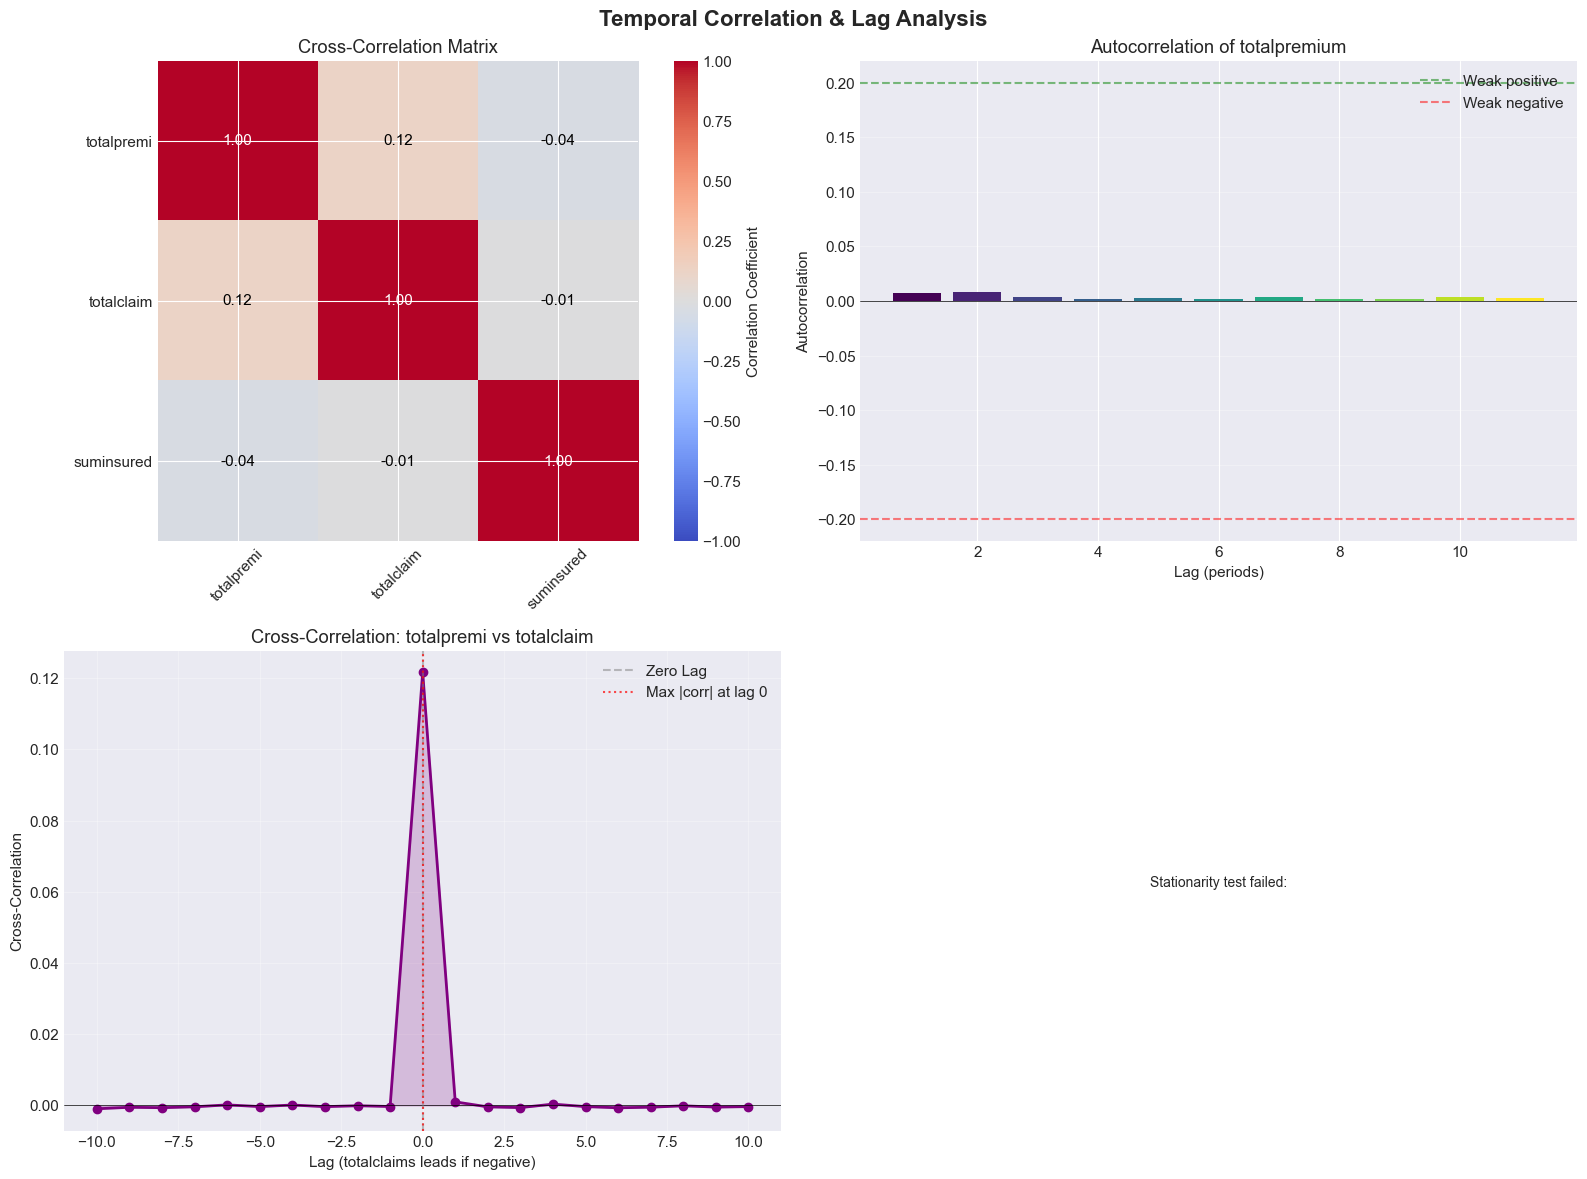

In [ ]:
# Cell 6: Time-Based Correlation & Lag Analysis
print("="*80)
print("🔥 TIME-BASED CORRELATION & LAG ANALYSIS")
print("="*80)

def analyze_temporal_correlation(df, date_col, value_cols, max_lag=12):
    """
    Analyze temporal correlations and lag effects
    """
    print(f"\n⏱️ Temporal Correlation Analysis")
    print(f"   • Date column: {date_col}")
    print(f"   • Metrics: {value_cols}")
    print(f"   • Max Lag: {max_lag} periods")
    
    # Prepare time series data
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Temporal Correlation & Lag Analysis', fontsize=16, fontweight='bold')
    
    # 1. Cross-Correlation Heatmap
    if len(value_cols) >= 2:
        ax1 = axes[0, 0]
        correlation_matrix = df_sorted[value_cols].corr()
        
        im = ax1.imshow(correlation_matrix.values, cmap='coolwarm', vmin=-1, vmax=1)
        ax1.set_title('Cross-Correlation Matrix')
        ax1.set_xticks(range(len(value_cols)))
        ax1.set_yticks(range(len(value_cols)))
        ax1.set_xticklabels([col[:10] for col in value_cols], rotation=45)
        ax1.set_yticklabels([col[:10] for col in value_cols])
        
        # Add correlation values
        for i in range(len(value_cols)):
            for j in range(len(value_cols)):
                ax1.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                        ha='center', va='center', color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')
        
        plt.colorbar(im, ax=ax1, label='Correlation Coefficient')
    else:
        axes[0, 0].text(0.5, 0.5, 'Need at least 2 metrics\nfor correlation matrix',
                       ha='center', va='center', fontsize=12)
        axes[0, 0].axis('off')
    
    # 2. Lag Analysis (Autocorrelation)
    if len(value_cols) >= 1:
        ax2 = axes[0, 1]
        primary_metric = value_cols[0]
        
        # Calculate autocorrelation
        lags = range(1, min(max_lag, len(df_sorted) // 10))
        autocorrs = []
        
        for lag in lags:
            if lag < len(df_sorted):
                autocorr = df_sorted[primary_metric].autocorr(lag=lag)
                autocorrs.append(autocorr)
            else:
                autocorrs.append(np.nan)
        
        bars = ax2.bar(lags, autocorrs, color=plt.cm.viridis(np.linspace(0, 1, len(lags))))
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax2.axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Weak positive')
        ax2.axhline(y=-0.2, color='red', linestyle='--', alpha=0.5, label='Weak negative')
        
        ax2.set_xlabel('Lag (periods)')
        ax2.set_ylabel('Autocorrelation')
        ax2.set_title(f'Autocorrelation of {primary_metric[:15]}')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Identify significant lags
        significant_lags = [lag for lag, ac in zip(lags, autocorrs) if abs(ac) > 0.2]
        if significant_lags:
            print(f"   • Significant autocorrelation at lags: {significant_lags}")
    else:
        axes[0, 1].text(0.5, 0.5, 'Need at least 1 metric\nfor autocorrelation',
                       ha='center', va='center', fontsize=12)
        axes[0, 1].axis('off')
    
    # 3. Lagged Cross-Correlation
    if len(value_cols) >= 2:
        ax3 = axes[1, 0]
        metric1, metric2 = value_cols[0], value_cols[1]
        
        # Calculate cross-correlation at different lags
        max_lag_calc = min(10, len(df_sorted) // 20)
        cross_corrs = []
        lags_range = range(-max_lag_calc, max_lag_calc + 1)
        
        for lag in lags_range:
            if lag >= 0:
                corr = df_sorted[metric1].corr(df_sorted[metric2].shift(lag))
            else:
                corr = df_sorted[metric1].shift(-lag).corr(df_sorted[metric2])
            cross_corrs.append(corr)
        
        ax3.plot(lags_range, cross_corrs, marker='o', color='purple', linewidth=2)
        ax3.fill_between(lags_range, cross_corrs, alpha=0.2, color='purple')
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Zero Lag')
        
        # Find max correlation
        max_corr_idx = np.nanargmax(np.abs(cross_corrs))
        max_corr_lag = lags_range[max_corr_idx]
        max_corr_value = cross_corrs[max_corr_idx]
        
        ax3.axvline(x=max_corr_lag, color='red', linestyle=':', alpha=0.7,
                   label=f'Max |corr| at lag {max_corr_lag}')
        
        ax3.set_xlabel(f'Lag ({metric2} leads if negative)')
        ax3.set_ylabel('Cross-Correlation')
        ax3.set_title(f'Cross-Correlation: {metric1[:10]} vs {metric2[:10]}')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        print(f"   • Max correlation ({max_corr_value:.3f}) at lag {max_corr_lag}")
        if max_corr_lag > 0:
            print(f"   • {metric1} leads {metric2} by {max_corr_lag} periods")
        elif max_corr_lag < 0:
            print(f"   • {metric2} leads {metric1} by {-max_corr_lag} periods")
        else:
            print(f"   • No lag - simultaneous relationship")
    else:
        axes[1, 0].text(0.5, 0.5, 'Need at least 2 metrics\nfor cross-correlation',
                       ha='center', va='center', fontsize=12)
        axes[1, 0].axis('off')
    
    # 4. Stationarity Test
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    if len(value_cols) >= 1:
        test_metric = value_cols[0]
        test_series = df_sorted[test_metric].dropna()
        
        if len(test_series) > 50:  # Need sufficient data for ADF test
            try:
                # Augmented Dickey-Fuller test
                adf_result = adfuller(test_series, autolag='AIC')
                
                stats_text = "📊 STATIONARITY ANALYSIS\n" + "="*40 + "\n\n"
                stats_text += f"Metric: {test_metric}\n"
                stats_text += f"Test: Augmented Dickey-Fuller\n\n"
                stats_text += f"ADF Statistic: {adf_result[0]:.4f}\n"
                stats_text += f"P-value: {adf_result[1]:.6f}\n"
                stats_text += f"Critical Values:\n"
                
                for key, value in adf_result[4].items():
                    stats_text += f"   {key}: {value:.3f}\n"
                
                stats_text += f"\n💡 INTERPRETATION:\n"
                if adf_result[1] < 0.05:
                    stats_text += "• REJECT null hypothesis\n"
                    stats_text += "• Series is STATIONARY\n"
                    stats_text += "• No unit root present\n"
                else:
                    stats_text += "• FAIL to reject null hypothesis\n"
                    stats_text += "• Series is NON-STATIONARY\n"
                    stats_text += "• Contains unit root\n"
                    stats_text += "• May need differencing\n"
                
                ax4.text(0.1, 0.95, stats_text, fontfamily='monospace', fontsize=9,
                        verticalalignment='top', transform=ax4.transAxes,
                        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
                
            except Exception as e:
                ax4.text(0.5, 0.5, f'Stationarity test failed:\n{str(e)[:50]}',
                        ha='center', va='center', fontsize=10)
        else:
            ax4.text(0.5, 0.5, 'Insufficient data\nfor stationarity test',
                    ha='center', va='center', fontsize=10)
    else:
        ax4.text(0.5, 0.5, 'Need at least 1 metric\nfor stationarity test',
                ha='center', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Return summary
    summary = {
        'metrics_analyzed': value_cols,
        'max_lag_analyzed': max_lag,
        'stationarity_tested': len(value_cols) >= 1
    }
    
    return summary

# Execute temporal correlation analysis
if len(available_metrics) >= 2:
    print("\n🔍 Performing temporal correlation analysis...")
    metrics_for_analysis = available_metrics[:min(3, len(available_metrics))]
    correlation_summary = analyze_temporal_correlation(df, primary_date_col, metrics_for_analysis, max_lag=12)
else:
    print("⚠️ Need at least 2 metrics for temporal correlation analysis")

📋 TIME-BASED SEGMENTATION ANALYSIS

🔍 Performing time-based segmentation...

🎯 Time Segmentation: Year Analysis
   • Date column: transactionmonth
   • Value column: totalpremium
   • Segment type: year


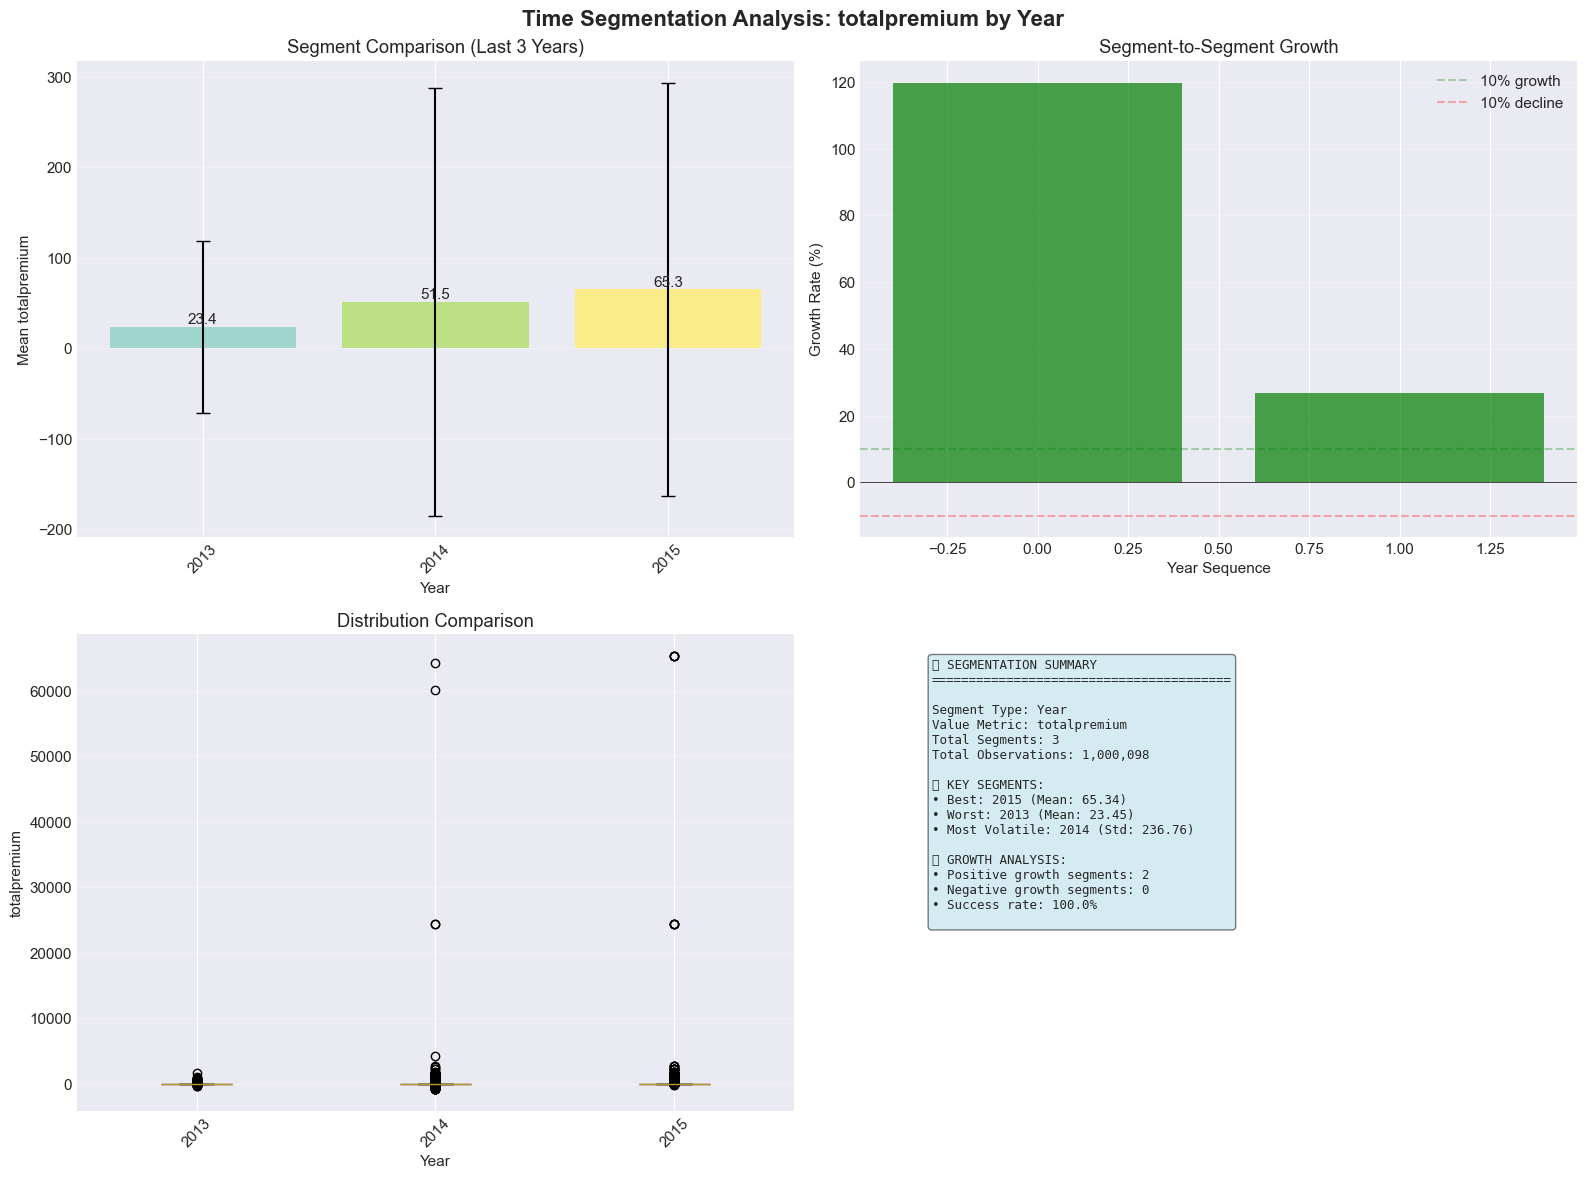


📋 SEGMENT STATISTICS TABLE (Last 5 segments):


,Count,Mean,Std,Min,Median,Max,Q1,Q3,Growth_Rate,YoY_Growth
Segment,,,,,,,,,,
2013,2736,23.45,95.18,-302.93,0.00,1653.48,0.0,2.84,NaN,NaN
2014,240628,51.53,236.76,-782.58,1.61,64291.06,0.0,15.79,119.744136,NaN
2015,756734,65.34,228.42,-96.49,2.36,65282.60,0.0,21.93,26.799922,NaN


✅ Year segmentation saved to CSV


In [ ]:
# Cell 7: Time-Based Segmentation Analysis
print("="*80)
print("📋 TIME-BASED SEGMENTATION ANALYSIS")
print("="*80)

def analyze_time_segments(df, date_col, value_col, segment_type='year'):
    """
    Analyze data segmented by time periods
    """
    print(f"\n🎯 Time Segmentation: {segment_type.capitalize()} Analysis")
    print(f"   • Date column: {date_col}")
    print(f"   • Value column: {value_col}")
    print(f"   • Segment type: {segment_type}")
    
    # Ensure date column is datetime
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # Extract segmentation column
    if segment_type == 'year':
        df['Segment'] = df[date_col].dt.year
        segment_label = 'Year'
    elif segment_type == 'quarter':
        df['Segment'] = df[date_col].dt.year.astype(str) + '-Q' + df[date_col].dt.quarter.astype(str)
        segment_label = 'Quarter'
    elif segment_type == 'month':
        df['Segment'] = df[date_col].dt.strftime('%Y-%m')
        segment_label = 'Month'
    elif segment_type == 'week':
        df['Segment'] = df[date_col].dt.strftime('%Y-W%U')
        segment_label = 'Week'
    else:
        df['Segment'] = df[date_col].dt.year  # Default to year
        segment_label = 'Year'
    
    # Calculate segment statistics
    segment_stats = df.groupby('Segment')[value_col].agg([
        'count', 'mean', 'std', 'min', 'median', 'max', 
        lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)
    ]).round(2)
    
    segment_stats.columns = ['Count', 'Mean', 'Std', 'Min', 'Median', 'Max', 'Q1', 'Q3']
    
    # Calculate segment growth
    segment_stats['Growth_Rate'] = segment_stats['Mean'].pct_change() * 100
    segment_stats['YoY_Growth'] = segment_stats['Mean'].pct_change(periods=4 if segment_type == 'quarter' else 12) * 100
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Time Segmentation Analysis: {value_col} by {segment_label}', 
                fontsize=16, fontweight='bold')
    
    # 1. Segment Comparison (Bar Chart)
    ax1 = axes[0, 0]
    segments = segment_stats.index.tolist()[-10:]  # Last 10 segments
    means = segment_stats.loc[segments, 'Mean']
    stds = segment_stats.loc[segments, 'Std']
    
    bars = ax1.bar(range(len(segments)), means, yerr=stds, 
                   capsize=5, alpha=0.8, color=plt.cm.Set3(np.linspace(0, 1, len(segments))))
    ax1.set_xlabel(segment_label)
    ax1.set_ylabel(f'Mean {value_col}')
    ax1.set_title(f'Segment Comparison (Last {len(segments)} {segment_label}s)')
    ax1.set_xticks(range(len(segments)))
    ax1.set_xticklabels([str(s)[-7:] for s in segments], rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean_val:.1f}', ha='center', va='bottom')
    
    # 2. Growth Analysis
    ax2 = axes[0, 1]
    valid_growth = segment_stats['Growth_Rate'].dropna()
    if len(valid_growth) > 0:
        colors = ['green' if g > 0 else 'red' for g in valid_growth]
        ax2.bar(range(len(valid_growth)), valid_growth.values, color=colors, alpha=0.7)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax2.axhline(y=10, color='green', linestyle='--', alpha=0.3, label='10% growth')
        ax2.axhline(y=-10, color='red', linestyle='--', alpha=0.3, label='10% decline')
        
        ax2.set_xlabel(f'{segment_label} Sequence')
        ax2.set_ylabel('Growth Rate (%)')
        ax2.set_title('Segment-to-Segment Growth')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
    else:
        ax2.text(0.5, 0.5, 'Insufficient data\nfor growth analysis',
                ha='center', va='center', fontsize=12)
        ax2.axis('off')
    
    # 3. Distribution Comparison (Box Plot)
    ax3 = axes[1, 0]
    segment_data = []
    segment_labels = []
    
    for segment in segments:
        segment_values = df[df['Segment'] == segment][value_col].dropna()
        if len(segment_values) > 0:
            segment_data.append(segment_values)
            segment_labels.append(str(segment)[-7:])
    
    if len(segment_data) > 1:
        box = ax3.boxplot(segment_data, patch_artist=True)
        for patch, color in zip(box['boxes'], plt.cm.Set3(np.linspace(0, 1, len(segment_data)))):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax3.set_xlabel(segment_label)
        ax3.set_ylabel(value_col)
        ax3.set_title(f'Distribution Comparison')
        ax3.set_xticks(range(1, len(segment_labels) + 1))
        ax3.set_xticklabels(segment_labels, rotation=45)
        ax3.grid(True, alpha=0.3, axis='y')
    else:
        ax3.text(0.5, 0.5, 'Insufficient segments\nfor distribution comparison',
                ha='center', va='center', fontsize=12)
        ax3.axis('off')
    
    # 4. Segment Statistics Summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Prepare summary text
    summary_text = f"📊 SEGMENTATION SUMMARY\n{'='*40}\n\n"
    summary_text += f"Segment Type: {segment_label}\n"
    summary_text += f"Value Metric: {value_col}\n"
    summary_text += f"Total Segments: {len(segment_stats)}\n"
    summary_text += f"Total Observations: {segment_stats['Count'].sum():,}\n\n"
    
    if not segment_stats.empty:
        best_segment = segment_stats['Mean'].idxmax()
        worst_segment = segment_stats['Mean'].idxmin()
        most_volatile = segment_stats['Std'].idxmax()
        
        summary_text += f"🎯 KEY SEGMENTS:\n"
        summary_text += f"• Best: {best_segment} (Mean: {segment_stats.loc[best_segment, 'Mean']:.2f})\n"
        summary_text += f"• Worst: {worst_segment} (Mean: {segment_stats.loc[worst_segment, 'Mean']:.2f})\n"
        summary_text += f"• Most Volatile: {most_volatile} (Std: {segment_stats.loc[most_volatile, 'Std']:.2f})\n\n"
        
        # Growth statistics
        if 'Growth_Rate' in segment_stats.columns:
            positive_growth = (segment_stats['Growth_Rate'] > 0).sum()
            negative_growth = (segment_stats['Growth_Rate'] < 0).sum()
            
            summary_text += f"📈 GROWTH ANALYSIS:\n"
            summary_text += f"• Positive growth segments: {positive_growth}\n"
            summary_text += f"• Negative growth segments: {negative_growth}\n"
            if positive_growth + negative_growth > 0:
                summary_text += f"• Success rate: {positive_growth/(positive_growth+negative_growth)*100:.1f}%\n"
    
    ax4.text(0.1, 0.95, summary_text, fontfamily='monospace', fontsize=9,
            verticalalignment='top', transform=ax4.transAxes,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Display segment statistics table
    print(f"\n📋 SEGMENT STATISTICS TABLE (Last 5 segments):")
    display(segment_stats.tail(5))
    
    return segment_stats

# Execute segmentation analysis
if available_metrics and primary_date_col:
    print("\n🔍 Performing time-based segmentation...")
    for segment_type in ['year', 'quarter', 'month']:
        try:
            segment_stats = analyze_time_segments(df, primary_date_col, available_metrics[0], segment_type)
            
            # Save segment statistics
            segment_stats.to_csv(f'time_segmentation_{segment_type}.csv')
            print(f"✅ {segment_type.capitalize()} segmentation saved to CSV")
            
            # Limit to one segmentation for demo
            break  
            
        except Exception as e:
            print(f"⚠️  Could not analyze {segment_type} segmentation: {e}")
else:
    print("⚠️ Cannot perform segmentation without metrics and date column")

In [ ]:
# Cell 8: Temporal Analysis Summary (WITH PROPER SAVING)
print("="*80)
print("📊 TEMPORAL ANALYSIS SUMMARY & INSIGHTS")
print("="*80)

# Import necessary libraries if not already imported
import calendar
import numpy as np
from pathlib import Path

def generate_temporal_insights(df, date_col, metrics):
    """
    Generate comprehensive temporal insights
    """
    print("\n🔍 GENERATING TEMPORAL INSIGHTS")
    print("-"*50)
    
    insights = []
    insight_data = []
    
    # 1. Time Range Analysis
    if pd.api.types.is_datetime64_any_dtype(df[date_col]):
        min_date = df[date_col].min()
        max_date = df[date_col].max()
        date_range = (max_date - min_date).days
        
        insight_text = f"📅 Time Range: {min_date.date()} to {max_date.date()} ({date_range} days)"
        insights.append(insight_text)
        insight_data.append({
            'category': 'Time Range',
            'insight': insight_text,
            'details': f'Coverage: {date_range/365:.1f} years'
        })
        
        # Data density
        total_days = date_range + 1
        data_days = df[date_col].dt.date.nunique()
        coverage_pct = data_days / total_days * 100
        density_text = f"   • Data Coverage: {data_days}/{total_days} days ({coverage_pct:.1f}%)"
        insights.append(density_text)
        insight_data.append({
            'category': 'Data Coverage',
            'insight': 'Data Density Analysis',
            'details': density_text.strip('   • ')
        })
    
    # 2. Temporal Pattern Detection
    best_month = None
    best_dow = None
    
    if 'Month' in df.columns and 'DayOfWeek' in df.columns:
        # Monthly pattern
        monthly_means = df.groupby('Month')[metrics[0]].mean() if metrics else pd.Series()
        if not monthly_means.empty and len(monthly_means) > 0:
            best_month = monthly_means.idxmax()
            worst_month = monthly_means.idxmin()
            month_name = calendar.month_name[best_month]
            month_insight = f"\n📈 Monthly Pattern: Best in {month_name} (Month {best_month})"
            insights.append(month_insight)
            insight_data.append({
                'category': 'Monthly Patterns',
                'insight': month_insight.strip('\n📈 '),
                'details': f'Worst in month {worst_month}'
            })
        
        # Day of week pattern
        dow_means = df.groupby('DayOfWeek')[metrics[0]].mean() if metrics else pd.Series()
        if not dow_means.empty and len(dow_means) > 0:
            best_dow = dow_means.idxmax()
            dow_insight = f"📅 Weekly Pattern: Highest values on {best_dow}"
            insights.append(dow_insight)
            insight_data.append({
                'category': 'Weekly Patterns',
                'insight': dow_insight.strip('📅 '),
                'details': f'Day {best_dow} shows peak performance'
            })
    
    # 3. Trend Analysis
    trend_results = []
    if date_col in df.columns and metrics:
        df_sorted = df.sort_values(date_col)
        for metric in metrics[:2]:  # First 2 metrics
            if metric in df.columns:
                # Calculate simple trend
                x = np.arange(len(df_sorted))
                y = df_sorted[metric].values
                valid_mask = ~np.isnan(y)
                
                if np.sum(valid_mask) > 10:
                    z = np.polyfit(x[valid_mask], y[valid_mask], 1)
                    slope = z[0]
                    
                    if slope > 0:
                        trend = f"UPWARD trend ({slope:.4f} per period)"
                    elif slope < 0:
                        trend = f"DOWNWARD trend ({abs(slope):.4f} per period)"
                    else:
                        trend = "STABLE (no significant trend)"
                    
                    trend_insight = f"\n📉 {metric}: Shows {trend}"
                    insights.append(trend_insight)
                    insight_data.append({
                        'category': 'Trend Analysis',
                        'insight': f'{metric} Trend',
                        'details': trend,
                        'slope': slope
                    })
                    trend_results.append({'metric': metric, 'trend': trend, 'slope': slope})
    
    # 4. Seasonality Detection
    seasonality_results = []
    if 'Month' in df.columns and metrics:
        for metric in metrics[:1]:  # First metric
            monthly_std = df.groupby('Month')[metric].std()
            if not monthly_std.empty:
                cv = monthly_std.mean() / df[metric].mean() * 100
                if cv > 30:
                    seasonality_text = f"\n🌊 {metric}: Shows strong seasonal variation (CV: {cv:.1f}%)"
                elif cv > 15:
                    seasonality_text = f"🌊 {metric}: Shows moderate seasonal variation (CV: {cv:.1f}%)"
                else:
                    seasonality_text = f"🌊 {metric}: Shows minimal seasonal variation (CV: {cv:.1f}%)"
                
                insights.append(seasonality_text)
                insight_data.append({
                    'category': 'Seasonality',
                    'insight': f'{metric} Seasonality',
                    'details': f'Coefficient of Variation: {cv:.1f}%'
                })
                seasonality_results.append({'metric': metric, 'cv': cv})
    
    # 5. Volatility Analysis
    volatility_results = []
    if metrics:
        for metric in metrics[:1]:
            rolling_vol = df[metric].rolling(window=30).std().dropna()
            if len(rolling_vol) > 0:
                avg_volatility = rolling_vol.mean()
                max_volatility = rolling_vol.max()
                volatility_ratio = max_volatility / avg_volatility if avg_volatility > 0 else 0
                
                vol_insight = f"\n⚡ {metric} Volatility:"
                insights.append(vol_insight)
                insights.append(f"   • Average 30-day volatility: {avg_volatility:.2f}")
                insights.append(f"   • Peak volatility: {max_volatility:.2f}")
                
                insight_data.append({
                    'category': 'Volatility',
                    'insight': f'{metric} Volatility Analysis',
                    'details': f'Avg: {avg_volatility:.2f}, Peak: {max_volatility:.2f}, Ratio: {volatility_ratio:.2f}'
                })
                volatility_results.append({
                    'metric': metric,
                    'avg_volatility': avg_volatility,
                    'max_volatility': max_volatility,
                    'volatility_ratio': volatility_ratio
                })
                
                if volatility_ratio > 2:
                    insights.append(f"   • ⚠️  Significant volatility spikes detected (ratio: {volatility_ratio:.1f}x)")
    
    # 6. Anomaly Detection
    anomaly_results = []
    if metrics:
        for metric in metrics[:1]:
            q1 = df[metric].quantile(0.25)
            q3 = df[metric].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            anomalies = df[(df[metric] < lower_bound) | (df[metric] > upper_bound)]
            anomaly_pct = len(anomalies) / len(df) * 100
            
            anomaly_insight = f"\n🚨 {metric} Anomalies:"
            insights.append(anomaly_insight)
            insights.append(f"   • {len(anomalies):,} potential anomalies ({anomaly_pct:.1f}%)")
            
            insight_data.append({
                'category': 'Anomalies',
                'insight': f'{metric} Anomaly Detection',
                'details': f'{len(anomalies):,} anomalies ({anomaly_pct:.1f}%)'
            })
            anomaly_results.append({
                'metric': metric,
                'anomaly_count': len(anomalies),
                'anomaly_pct': anomaly_pct
            })
            
            if anomaly_pct > 5:
                insights.append(f"   • ⚠️  High anomaly rate (>5%) - investigate further")
    
    # 7. Recommendations
    insights.append(f"\n💡 RECOMMENDATIONS:")
    
    # Check data quality
    if date_col in df.columns:
        date_completeness = df[date_col].notnull().mean() * 100
        if date_completeness < 90:
            rec_text = f"   • Improve date completeness ({date_completeness:.1f}% complete)"
            insights.append(rec_text)
            insight_data.append({
                'category': 'Recommendations',
                'insight': 'Data Quality Improvement',
                'details': rec_text.strip('   • ')
            })
    
    # Suggest further analysis
    recommendations = [
        "   • Consider deeper seasonality analysis (weekly, daily patterns)",
        "   • Analyze lead-lag relationships between key metrics",
        "   • Implement forecasting models based on identified patterns",
        "   • Investigate causes of volatility spikes",
        "   • Validate anomaly detection with business rules"
    ]
    
    for rec in recommendations:
        insights.append(rec)
        insight_data.append({
            'category': 'Recommendations',
            'insight': 'Analytical Next Steps',
            'details': rec.strip('   • ')
        })
    
    # Print insights
    print("\n".join(insights))
    
    # Create comprehensive insights DataFrame
    insights_df = pd.DataFrame(insight_data)
    
    # Add additional columns if needed
    if 'slope' not in insights_df.columns:
        insights_df['slope'] = None
    if 'cv' not in insights_df.columns:
        insights_df['cv'] = None
    
    return insights_df, {
        'trends': trend_results,
        'seasonality': seasonality_results,
        'volatility': volatility_results,
        'anomalies': anomaly_results,
        'best_month': best_month,
        'best_dow': best_dow,
        'date_range': date_range if 'date_range' in locals() else None,
        'coverage_pct': coverage_pct if 'coverage_pct' in locals() else None
    }

# Generate insights
if primary_date_col and available_metrics:
    print("\n🔍 Generating comprehensive temporal insights...")
    insights_df, detailed_results = generate_temporal_insights(df, primary_date_col, available_metrics[:3])
    
    # FIXED: Save insights to reports folder
    reports_dir = Path("../../reports")
    reports_dir.mkdir(parents=True, exist_ok=True)
    
    # Save insights as CSV
    insights_csv_path = reports_dir / "temporal_analysis_insights.csv"
    insights_df.to_csv(insights_csv_path, index=False)
    
    # Save detailed results as JSON
    import json
    results_json_path = reports_dir / "temporal_analysis_detailed_results.json"
    with open(results_json_path, 'w') as f:
        # Convert non-serializable objects
        serializable_results = {}
        for key, value in detailed_results.items():
            if isinstance(value, list):
                serializable_results[key] = value
            elif isinstance(value, (int, float, str, bool, type(None))):
                serializable_results[key] = value
            else:
                serializable_results[key] = str(value)
        json.dump(serializable_results, f, indent=2, default=str)
    
    # Create markdown summary for GitHub
    md_path = reports_dir / "temporal_analysis_summary.md"
    with open(md_path, 'w') as f:
        f.write("# Temporal Analysis Summary\n\n")
        f.write(f"**Analysis Date:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write(f"**Dataset:** {df.shape[0]} rows × {df.shape[1]} columns\n\n")
        f.write(f"**Primary Date Column:** {primary_date_col}\n\n")
        f.write(f"**Metrics Analyzed:** {', '.join(available_metrics[:3])}\n\n")
        
        f.write("## Key Findings\n\n")
        
        # Time Range
        if detailed_results.get('date_range'):
            f.write(f"### Time Coverage\n")
            f.write(f"- **Date Range:** {detailed_results['date_range']} days\n")
            f.write(f"- **Data Coverage:** {detailed_results['coverage_pct']:.1f}%\n\n")
        
        # Trends
        if detailed_results.get('trends'):
            f.write("### Trend Analysis\n")
            for trend in detailed_results['trends']:
                f.write(f"- **{trend['metric']}:** {trend['trend']}\n")
            f.write("\n")
        
        # Seasonality
        if detailed_results.get('seasonality'):
            f.write("### Seasonality\n")
            for season in detailed_results['seasonality']:
                cv = season['cv']
                if cv > 30:
                    strength = "Strong"
                elif cv > 15:
                    strength = "Moderate"
                else:
                    strength = "Minimal"
                f.write(f"- **{season['metric']}:** {strength} seasonality (CV: {cv:.1f}%)\n")
            f.write("\n")
        
        # Anomalies
        if detailed_results.get('anomalies'):
            f.write("### Anomaly Detection\n")
            for anomaly in detailed_results['anomalies']:
                f.write(f"- **{anomaly['metric']}:** {anomaly['anomaly_count']} anomalies ({anomaly['anomaly_pct']:.1f}%)\n")
            f.write("\n")
        
        # Recommendations
        f.write("## Recommendations\n\n")
        f.write("1. **Deepen seasonal analysis** with weekly/daily granularity\n")
        f.write("2. **Investigate volatility spikes** for potential data quality issues\n")
        f.write("3. **Validate anomalies** against business rules\n")
        f.write("4. **Implement forecasting models** for key metrics\n")
        f.write("5. **Analyze lead-lag relationships** between correlated variables\n\n")
        
        f.write("## Next Steps\n\n")
        f.write("Proceed to outlier detection and advanced time series modeling.\n")
    
    print(f"\n✅ Temporal insights saved to reports folder:")
    print(f"   • Insights CSV: {insights_csv_path.name}")
    print(f"   • Detailed JSON: {results_json_path.name}")
    print(f"   • Markdown Summary: {md_path.name}")
    
    print(f"\n📋 INSIGHTS SUMMARY TABLE:")
    display(insights_df.head(10))
else:
    print("⚠️ Cannot generate insights without date column and metrics")

print(f"\n" + "="*80)
print("🎯 TEMPORAL ANALYSIS COMPLETE")
print("="*80)

# Summary of all outputs generated
print(f"\n📁 OUTPUTS GENERATED IN REPORTS FOLDER:")

# List temporal analysis files
temporal_files = list(reports_dir.glob("*temporal*"))
if temporal_files:
    for file in temporal_files:
        size_kb = file.stat().st_size / 1024
        print(f"   • {file.name} ({size_kb:.1f} KB)")
else:
    print("   (No temporal files found - check if save was successful)")

print(f"\n📊 KEY DELIVERABLES:")
print(f"   1. Time series visualizations")
print(f"   2. Aggregated pattern analysis")
print(f"   3. Correlation & lag analysis")
print(f"   4. Time-based segmentation")
print(f"   5. Comprehensive insights report")

print(f"\n🚀 NEXT STEPS:")
print(f"   Proceed to 05_outlier_detection.ipynb")
print("="*80)

📊 TEMPORAL ANALYSIS SUMMARY & INSIGHTS

🔍 Generating comprehensive temporal insights...

🔍 GENERATING TEMPORAL INSIGHTS
--------------------------------------------------
📅 Time Range: 2013-10-01 to 2015-08-01 (669 days)
   • Data Coverage: 23/670 days (3.4%)

📈 Monthly Pattern: Best in April (Month 4)
📅 Weekly Pattern: Highest values on Wednesday

📉 totalpremium: Shows UPWARD trend (0.0000 per period)

📉 totalclaims: Shows DOWNWARD trend (0.0000 per period)

🌊 totalpremium: Shows strong seasonal variation (CV: 360.8%)

⚡ totalpremium Volatility:
   • Average 30-day volatility: 118.42
   • Peak volatility: 13002.88
   • ⚠️  Significant volatility spikes detected (ratio: 109.8x)

🚨 totalpremium Anomalies:
   • 209,042 potential anomalies (20.9%)
   • ⚠️  High anomaly rate (>5%) - investigate further

💡 RECOMMENDATIONS:
   • Consider deeper seasonality analysis (weekly, daily patterns)
   • Analyze lead-lag relationships between key metrics
   • Implement forecasting models based on iden

,category,insight,details,slope,cv
0,Time Range,📅 Time Range: 2013-10-01 to 2015-08-01 (669 days),Coverage: 1.8 years,NaN,None
1,Data Coverage,Data Density Analysis,Data Coverage: 23/670 days (3.4%),NaN,None
2,Monthly Patterns,Monthly Pattern: Best in April (Month 4),Worst in month 9,NaN,None
3,Weekly Patterns,Weekly Pattern: Highest values on Wednesday,Day Wednesday shows peak performance,NaN,None
4,Trend Analysis,totalpremium Trend,UPWARD trend (0.0000 per period),0.000021,None
5,Trend Analysis,totalclaims Trend,DOWNWARD trend (0.0000 per period),-0.000029,None
6,Seasonality,totalpremium Seasonality,Coefficient of Variation: 360.8%,NaN,None
7,Volatility,totalpremium Volatility Analysis,"Avg: 118.42, Peak: 13002.88, Ratio: 109.80",NaN,None
8,Anomalies,totalpremium Anomaly Detection,"209,042 anomalies (20.9%)",NaN,None
9,Recommendations,Analytical Next Steps,"Consider deeper seasonality analysis (weekly, ...",NaN,None



🎯 TEMPORAL ANALYSIS COMPLETE

📁 OUTPUTS GENERATED IN REPORTS FOLDER:
   • temporal_analysis_detailed_results.json (0.8 KB)
   • temporal_analysis_insights.csv (1.2 KB)
   • temporal_analysis_summary.md (1.0 KB)

📊 KEY DELIVERABLES:
   1. Time series visualizations
   2. Aggregated pattern analysis
   3. Correlation & lag analysis
   4. Time-based segmentation
   5. Comprehensive insights report

🚀 NEXT STEPS:
   Proceed to 05_outlier_detection.ipynb
